In [1]:
!pip install -q transformers

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

MODEL_NAME = 'Qwen/Qwen2.5-32B-Instruct'

device = 'cuda'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.padding_side = "left"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map='auto',
    dtype=torch.float16,
    trust_remote_code=True
)
model.eval()

Loading checkpoint shards:   0%|          | 0/17 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 5120)
    (layers): ModuleList(
      (0-63): 64 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=True)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=True)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=True)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=5120, out_features=27648, bias=False)
          (up_proj): Linear(in_features=5120, out_features=27648, bias=False)
          (down_proj): Linear(in_features=27648, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((5120,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((5120,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((5120,), eps=1e-06)
    (

In [5]:
BATCH_SIZE = 64
PRED_PATH = 'predictions_en (1).txt'
GD_PATH = 'public_test.vi.txt'

In [4]:
def make_prompt(pred, tgt):
    prompt = f"""
You are an expert medical translator and evaluator.
Evaluate the quality of the predicted translation from English to Vietnamese (Prediction) compared with the reference translation (Ground Truth).
Provide only two numbers: Fluency and Adequacy, each on a 1-5 scale, separated by a space.
Fluency comes first, then Adequacy. Do NOT write anything else.
In medical translation, Adequacy (faithfulness) is especially important: ensure medical terms, dosages, conditions, and instructions are accurately translated.

Example 1:
Prediction: "Bệnh nhân nên uống 2 viên paracetamol mỗi ngày."
Ground Truth: "Bệnh nhân cần uống 2 viên paracetamol mỗi ngày."
Output: 5 5

Example 2:
Prediction: "Tiêm vắc-xin trước khi mang thai."
Ground Truth: "Tiêm vắc-xin trước khi có thai."
Output: 5 4

Now evaluate the following translation:

Prediction: "{pred}"
Ground Truth: "{tgt}"
Output:"""
    return prompt

In [12]:
fluencies = []
adequacies = []

with open(PRED_PATH, 'r', encoding='utf-8') as f:
    preds = f.read().splitlines()
with open(GD_PATH, 'r', encoding='utf-8') as f:
    tgts = f.read().splitlines()


def parse_output(text):
    try:
        text = text.split('Now evaluate the following translation:')[1].strip()
        text = text.split('Output:')[1].strip()
        fluency, adequacy = map(int, text.split()[:2])
    except:
        fluency, adequacy = -1, -1
    return fluency, adequacy


for i in tqdm(range(0, len(preds), BATCH_SIZE)):
    batch_preds = preds[i:i+BATCH_SIZE]
    batch_tgts = tgts[i:i+BATCH_SIZE]
    
    batch_prompts = [make_prompt(p, t) for p, t in zip(batch_preds, batch_tgts)]
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=32,
            do_sample=False
        )
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    for text in decoded:
        f, a = parse_output(text)
        fluencies.append(f)
        adequacies.append(a)

100%|██████████| 47/47 [05:33<00:00,  7.10s/it]


In [13]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 86.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 141.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 146.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 209.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━ 3/7 [fonttools]  WARNING: The scripts fonttools, pyftmerge, pyftsubset and ttx are installed in '/home/admin/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


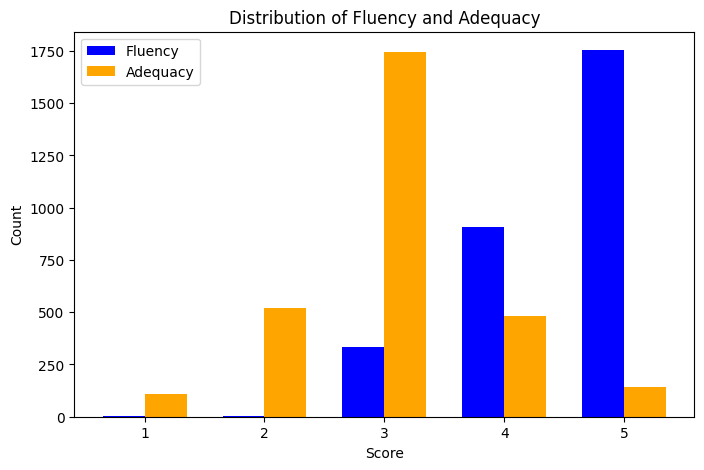

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

fluency_counts = [fluencies.count(i) for i in range(1,6)]
adequacy_counts = [adequacies.count(i) for i in range(1,6)]

x = range(1,6)
width = 0.35

plt.figure(figsize=(8,5))
plt.bar([i - width/2 for i in x], fluency_counts, width=width, label='Fluency', color='blue')
plt.bar([i + width/2 for i in x], adequacy_counts, width=width, label='Adequacy', color='orange')

plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Fluency and Adequacy')
plt.xticks(x)
plt.legend()
plt.show()

In [15]:
print(f'AVG Fluency: {sum(fluencies) / len(fluencies):.2f}')
print(f'AVG Adequacy: {sum(adequacies) / len(adequacies):.2f}')

AVG Fluency: 4.47
AVG Adequacy: 3.01


In [17]:
for i in range(len(adequacies)):
    if adequacies[i] == 1:
        print(f'Ground truth: {tgts[i]}')
        print(f'Prediction: {preds[i]}')
        print('-'*50)

Ground truth: Thời gian uống thuốc thử là 14 ngày.
Prediction: Thời gian nuôi ăn là 14 ngày.
--------------------------------------------------
Ground truth: Khảo sát sơ bộ thành phần hoá học và sàng lọc một số tác dụng sinh học in vitro cây cam thảo đá bia (Jasminanthes Tuyetanhiae T.B. Tran & Rodda, apocynaceae)
Prediction: Bước đầu khảo sát thành phần hoá học và hoạt tính sinh học in vitro của cây Cỏ sữa lá nhỏ (Jasminanthes Tuyetanhiae T. B. Tran & Rodda, Apocynaceae
--------------------------------------------------
Ground truth: Đánh giá kiến thức của bà mẹ có con mắc bệnh lồng ruột cấp tính điều trị tại khoa Ngoại tổng hợp, bệnh viện Đa khoa tỉnh Nam Định
Prediction: Phân tích kiến thức của bà mẹ về việc điều trị tại bệnh viện nhân dân tỉnh Nam Định
--------------------------------------------------
Ground truth: Nở ngày đất (Gomphrena celosioides Mart.
Prediction: Tại Việt Nam, loài này được ghi nhận ở Việt Nam là Gomphrena celosioides Mart.
------------------------------------